# Chapter 4.5. Adaptive variants of gradient descent

Original code in Nikolenko book was made in TensorFlow 1.x (TF1), but here I will convert examples to TensorFlow 2.0 (TF2).

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from metrics import accuracy
from utils import (
    _fix_seeds,
    plot_metric_history,
    plot_repeated_exp_metrics,
    show_images
)
from models_classes import (
    SimpleModel,
    BNModel,
    XavierModel,
    XavierBNModel
)

matplotlib.style.use('seaborn-poster')

## 1. Load data

- MNIST have 70k images (1 channel) with size of 28x28 (784 if flatten). 
- Samples have already splitted into train (60k images) and test (10k images). 
- Target classes in categorical view

In [2]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist
X_train, X_test = X_train / 255.0, X_test / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = tf.cast(X_train.reshape(-1, 784), tf.float32)
y_train = tf.cast(tf.one_hot(y_train, 10), tf.float32)

X_test = tf.cast(X_test.reshape(-1, 784), tf.float32)
y_test = tf.cast(tf.one_hot(y_test, 10), tf.float32)   

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


## 2. Train and evaluate different models 100 times

- SimpleModel: 3 FC layers
- BNModel: 3 FC layers with 1 BN layer
- XavierModel: 3 FC layers with Xavier initialization
- XavierBNModel: 3 FC layers with 1 BN layer and Xavier initialization

In [3]:
# define train proces
def train(model, X, y, optimizer):
    """
    One step of train process
    
    params:
        model: model object to train
        X: data
        y: target 
        optimizer: tf optimizer
    return:
        loss_val: loss value
    """
    with tf.GradientTape() as t:
        y_pred_logit = model(X)
        loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_pred_logit))
        
    grads = t.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    acc = accuracy(y, tf.nn.softmax(y_pred_logit))
    
    return loss_val, acc


# define evaluate proces
def evaluate(model, X, y):
    """
    One step of evaluation process
    
    params:
        model: model object to evaluate
        X: data to evaluate
        y: target 
    return:
        loss_val: loss value
    """
    y_pred_logit = model(X)
    loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_pred_logit))
    
    acc = accuracy(y, tf.nn.softmax(y_pred_logit))
    
    return loss_val, acc


def one_experiment(X_train, y_train, X_test, y_test, \
                   model, optimizer, 
                   num_steps=1000, batch_size=128):
    """
    Run one experiment.
    
    returns:
        loss_history: dict of lists
        acc_history: dict of lists
    """
    # collect metrics
    loss_history = {
        'train': [],
        'test': []
    }
    acc_history = {
        'train': [],
        'test': []
    }

    # running optimization
    for i in range(num_steps):

        # select train data batch
        indices = np.random.choice(len(X_train), batch_size)
        X_train_batch, y_train_batch = tf.gather(X_train, indices, axis=0), tf.gather(y_train, indices, axis=0)

        # train model
        train_loss, train_acc = train(model, X_train_batch, y_train_batch, optimizer)

        # select test data batch
        indices = np.random.choice(len(X_test), batch_size)
        X_test_batch, y_test_batch = tf.gather(X_test, indices, axis=0), tf.gather(y_test, indices, axis=0)  

        # evaluate model
        test_loss, test_acc = evaluate(model, X_test_batch, y_test_batch)

        # collect current metrics
        loss_history['train'].append(train_loss.numpy())
        loss_history['test'].append(test_loss.numpy())
        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        
    return loss_history, acc_history

def get_plain_loss(loss_history_exp, acc_history_exp):
    
    loss_plain_mtrx = {
    'train':[],
    'test':[]
    }
    acc_plain_mtrx = {
        'train':[],
        'test':[]    
    }

    for exp_loss, exp_acc in zip(loss_history_exp, acc_history_exp):
        loss_plain_mtrx['train'].append(exp_loss['train'])
        loss_plain_mtrx['test'].append(exp_loss['test'])

        acc_plain_mtrx['train'].append(exp_acc['train'])
        acc_plain_mtrx['test'].append(exp_acc['test']) 

    loss_plain_mtrx['train'] = np.array(loss_plain_mtrx['train'])
    loss_plain_mtrx['test'] = np.array(loss_plain_mtrx['test'])

    acc_plain_mtrx['train'] = np.array(acc_plain_mtrx['train'])
    acc_plain_mtrx['test'] = np.array(acc_plain_mtrx['test'])
    
    return loss_plain_mtrx, acc_plain_mtrx

### 2.1 SimpleModel, optimizer SGD (nesterov momentum)

In [4]:
%%time
# set constants
_fix_seeds(42)

lr = 1e-2
wd = 1e-5
batch_size = 128
num_steps = 200
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Set up model and optimier
    model = SimpleModel()
    optimizer = tf.optimizers.SGD(learning_rate=lr, decay=wd, nesterov=True, momentum=0.9)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size)
        
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]

CPU times: user 5min 13s, sys: 16.5 s, total: 5min 29s
Wall time: 2min 22s


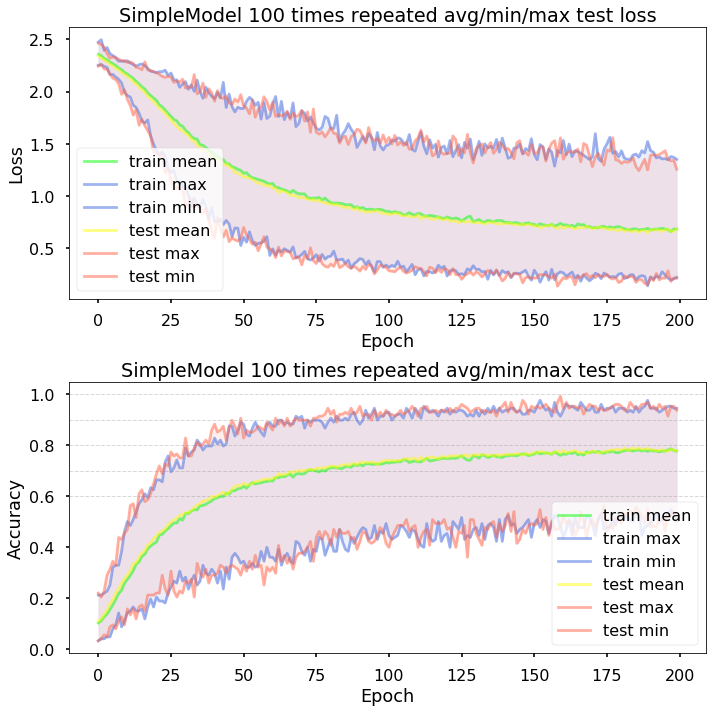

In [5]:
loss_plain_mtrx, acc_plain_mtrx = get_plain_loss(loss_history_exp, acc_history_exp)
plot_repeated_exp_metrics(loss_plain_mtrx, acc_plain_mtrx, repeat_num, num_steps, model_name=model.__name__)

### 2.2 BNModel with optimizer SGD (nesterov momentum)

In [6]:
%%time
# set constants
_fix_seeds(42)

lr = 1e-2
wd = 1e-5
batch_size = 128
num_steps = 200
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Set up model and optimier
    model = BNModel()
    optimizer = tf.optimizers.SGD(learning_rate=lr, decay=wd, nesterov=True, momentum=0.9)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size)
        
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)

100%|██████████| 100/100 [04:13<00:00,  2.53s/it]

CPU times: user 8min 4s, sys: 30.1 s, total: 8min 35s
Wall time: 4min 13s


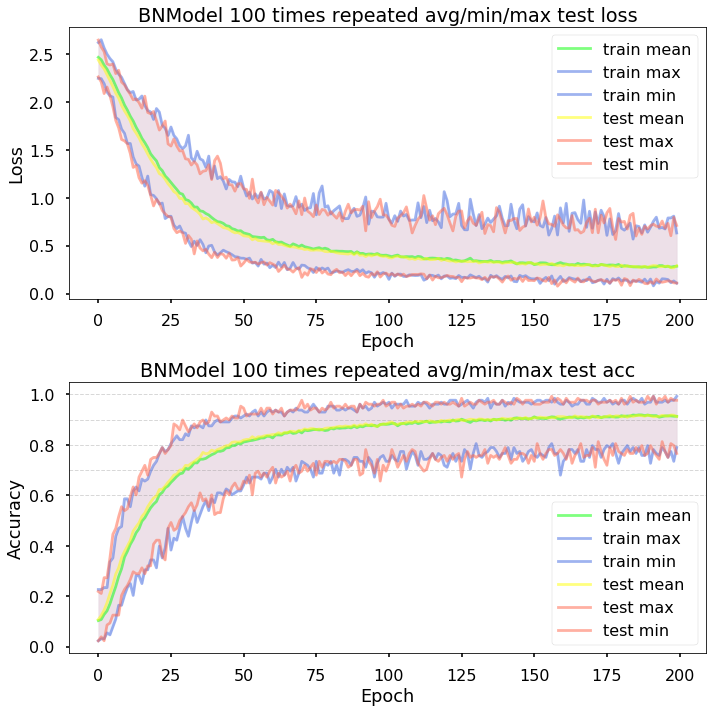

In [7]:
loss_plain_mtrx, acc_plain_mtrx = get_plain_loss(loss_history_exp, acc_history_exp)
plot_repeated_exp_metrics(loss_plain_mtrx, acc_plain_mtrx, repeat_num, num_steps, model_name=model.__name__)

### 2.3. XavierModel with optimizer SGD (nesterov momentum)

In [8]:
%%time
# set constants
_fix_seeds(42)

lr = 1e-2
wd = 1e-5
batch_size = 128
num_steps = 200
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Set up model and optimier
    model = XavierModel()
    optimizer = tf.optimizers.SGD(learning_rate=lr, decay=wd, nesterov=True, momentum=0.9)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size) 
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)

100%|██████████| 100/100 [02:31<00:00,  1.51s/it]

CPU times: user 5min 30s, sys: 17.2 s, total: 5min 47s
Wall time: 2min 31s


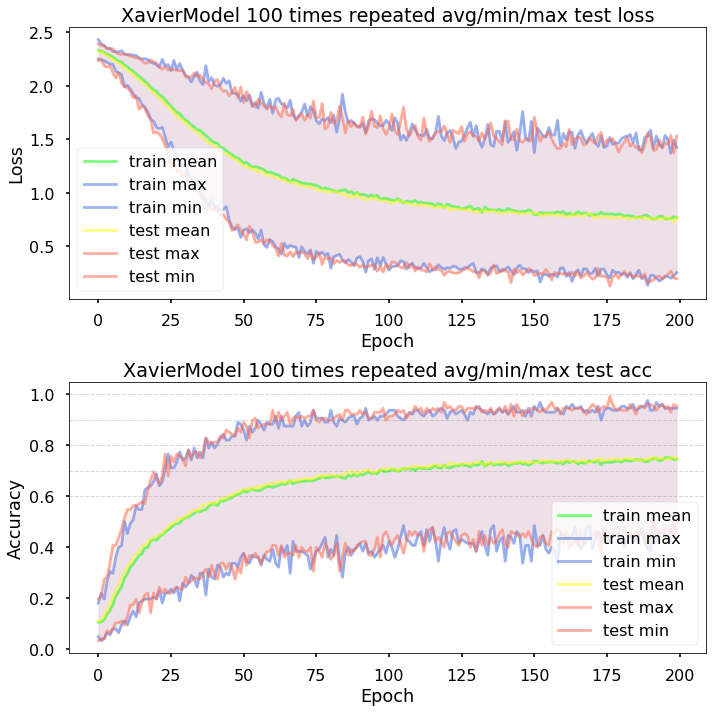

In [9]:
loss_plain_mtrx, acc_plain_mtrx = get_plain_loss(loss_history_exp, acc_history_exp)
plot_repeated_exp_metrics(loss_plain_mtrx, acc_plain_mtrx, repeat_num, num_steps, model_name=model.__name__)

### 2.4. XavierBNModel with optimizer SGD (nesterov momentum)

In [10]:
%%time
# set constants
_fix_seeds(42)

lr = 1e-2
wd = 1e-5
batch_size = 128
num_steps = 200
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Set up model and optimier
    model = XavierBNModel()
    optimizer = tf.optimizers.SGD(learning_rate=lr, decay=wd, nesterov=True, momentum=0.9)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size)
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)

100%|██████████| 100/100 [04:23<00:00,  2.64s/it]

CPU times: user 8min 21s, sys: 30.7 s, total: 8min 51s
Wall time: 4min 23s


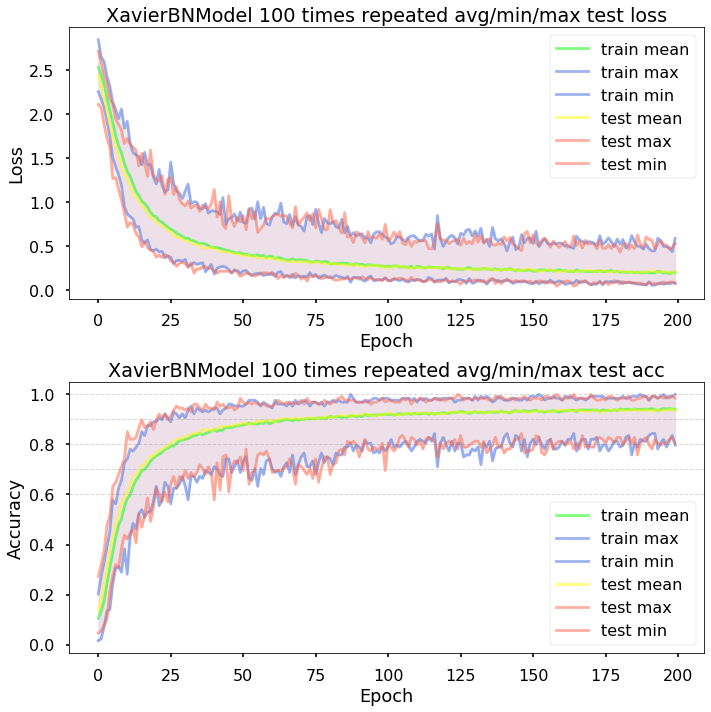

In [11]:
loss_plain_mtrx, acc_plain_mtrx = get_plain_loss(loss_history_exp, acc_history_exp)
plot_repeated_exp_metrics(loss_plain_mtrx, acc_plain_mtrx, repeat_num, num_steps, model_name=model.__name__)

### 2.5. XavierBNModel with optimizer Adam

In [12]:
%%time
# set constants
_fix_seeds(42)

lr = 1e-2
wd = 1e-5
batch_size = 128
num_steps = 200
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Set up model and optimier
    model = XavierBNModel()
    optimizer = tf.optimizers.Adam(learning_rate=lr, decay=wd)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size)
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)

100%|██████████| 100/100 [04:17<00:00,  2.58s/it]

CPU times: user 8min 44s, sys: 33.7 s, total: 9min 18s
Wall time: 4min 17s


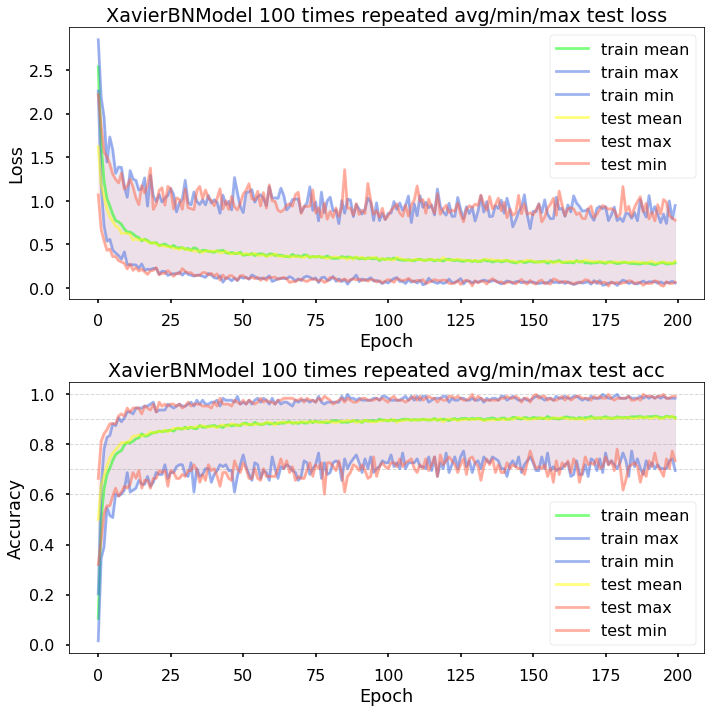

In [13]:
loss_plain_mtrx, acc_plain_mtrx = get_plain_loss(loss_history_exp, acc_history_exp)
plot_repeated_exp_metrics(loss_plain_mtrx, acc_plain_mtrx, repeat_num, num_steps, model_name=model.__name__)

## 3. Comparison of all models